In [50]:
from typing import TypedDict, List
from langgraph.graph import StateGraph, END
from langchain.prompts import PromptTemplate
from langchain.schema import HumanMessage
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image
from dotenv import load_dotenv
import os

In [51]:
groq = os.getenv("GROQ_API_KEY")
groq

'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'

In [52]:
class State(TypedDict):
    text: str
    classification: str
    entities: List[str]
    summary: str

In [53]:
from langchain_groq import ChatGroq

llm = ChatGroq(
    temperature=0.0,
    api_key=groq,
    model="llama-3.3-70b-versatile"
)

result = llm.invoke("Hi, how are you?")
print(result.content)

I'm just a language model, so I don't have feelings or emotions like humans do, but I'm functioning properly and ready to help with any questions or tasks you might have. How about you? How's your day going so far?


In [54]:
def classification_node(state: State):
    prompt = PromptTemplate(
        input_variable = ["text"],
        template = "Classify the following text into one of the following categories: News, Blog, Research or Other. DO NOT PROVIDE REASON.\n\nText:{text}\n\nCategory:"
    )
    message = HumanMessage(content = prompt.format(text = state["text"]))

    classification  = llm.invoke([message]).content.strip()
    return {"classification":classification}

def entity_extraction_node(state: State):
    prompt = PromptTemplate(
        input_variables = ["text"],
        template = "Extract all entities (Person, Organisation, Location, etc.) from the following text. Provide the result as a comma separated list. \n\n {text} \n\n Entities:"
    )

    message = HumanMessage(content = prompt.format(text = state["text"]))

    entities = llm.invoke([message]).content.strip().split(",  ")
    return {"entities":entities}

def summarization_node(state: State):
    prompt = PromptTemplate(
        input_variable = ["text"],
        template = "Summarize the following text into a small text\n\nText:{text}\n\nSummary:"
    )
    message = HumanMessage(content = prompt.format(text = state["text"]))

    summary  = llm.invoke([message]).content.strip()
    return {"summary":summary}

In [55]:
workflow = StateGraph(State)

workflow.add_node("classification_node", classification_node)
workflow.add_node("entity_extraction_node", entity_extraction_node)
workflow.add_node("summarization_node", summarization_node)

workflow.set_entry_point("classification_node")
workflow.add_edge("classification_node", "entity_extraction_node")
workflow.add_edge("entity_extraction_node", "summarization_node")
workflow.add_edge("summarization_node", END)

app = workflow.compile()


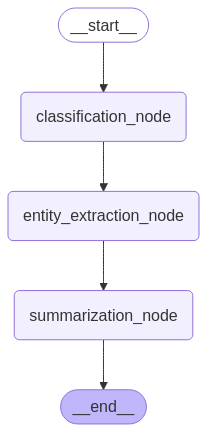

In [56]:
display(
    Image(
        app.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [57]:
SAMPLE_TEXT = '''Papa John’s International, Inc., a Delaware corporation (referred to as the “Company,” “Papa John’s,” “Papa Johns” or in 
the first person notations of “we,” “us” and “our”), operates and franchises pizza delivery and carryout restaurants and, in 
certain international markets, dine-in and delivery restaurants under the trademark “Papa Johns.” Papa John’s began 
operations in 1984. At December 31, 2023, there were 5,906 Papa John’s restaurants in operation, consisting of 648 
Company-owned and 5,258 franchised restaurants operating in 50 countries and territories. Our Company-owned 
restaurants include 98 restaurants operated under three joint venture arrangements. In discussions of our business, 
“Domestic” is defined as within the contiguous United States, “North America” includes Canada, and “International” 
includes the rest of the world other than North America. '''
state_input = {"text": SAMPLE_TEXT}
result = app.invoke(state_input)

In [58]:
print("Classication:", result["classification"])
print("\nEntities:", result["entities"])
print("\nSummary:", result["summary"])

Classication: Research

Entities: ["Papa John's International, Inc., Papa John's, Papa Johns, Delaware, United States, Canada, North America"]

Summary: Papa John's is a pizza restaurant chain that operates and franchises locations globally. As of 2023, there are 5,906 restaurants in 50 countries, with 648 company-owned and 5,258 franchised locations.
